<a href="https://colab.research.google.com/github/amritasidhu/COSC310FinalProject/blob/main/A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A6 (10 Marks)
---
**Focus**: CUDA Basics - Introduction (Warming Up!!)

© 2021 Dr. Scott Fazackerley (Based on labs from Dr. Abdallah Mohamed © 2020)

For this course, we are going to be using Google Colab version and takes advantage of the free Cloud GPUs offered through the platform for CUDA development. Colab Notebooks (you're reading one right now!) are typically designed to run Python code, however, we'll be modifying them in such a way that we can run CUDA code (as discussed in the lectures) on the GPU.

Please note that your code will be written and run directly within this assignment. You will need to save a local copy and ensure that you save and upload your completed notebook to your GitHub repo for submission.   You will also need to provide screenshots of output in many cases for submissions.  

**CRITICAL**
Lastly, keep in mind that anytime your runtime disconnects or is restarted **you must re-run the Notebook Setup code block**. This applies to all CUDA assignments done using Google Colab.

## Notebook Setup: GPU Runtime

Before writing/running any CUDA code, we need to ensure Colab is provisioning a Cloud GPU for us. To do this, click on the "Runtime" menu item in the top bar and select the "Change runtime type" option. Select "GPU" from the list of Hardware accelerators and click "Ok". 

## Notebook Setup: CUDA Compilation

To enable CUDA code compilation on Colab Notebooks, we'll employ use of the NVCC4Jupyter plugin (source code/documentation available [here](https://github.com/UBCO-COSC-407-Winter-2021-Term-1/nvcc4jupyter). This plugin effectively turns any Colab Notebook code block that includes `%%cu` into compilable/runnable CUDA code.

To download/install/enable NVCC4Jupyter, please run the following code block. **Running this block is required anytime you connect/restart/reconnect to an instance.** To run a code block, mouse over it and click the play button on left side.

You should see some output when you click the play button. Wait until the code block is finished running (this is indicated when the stop button goes away). The last couple lines of output should look something like the following:

```
created output directory at /content/src
Out bin /content/result.out
```

If your last two lines of output look something like above, you're ready to begin the assignment!

In [2]:
# Run the following to configure your notebook for CUDA code
!pip install git+git://github.com/UBCO-COSC-407-Winter-2021-Term-1/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning git://github.com/UBCO-COSC-407-Winter-2021-Term-1/nvcc4jupyter.git to /tmp/pip-req-build-exb0tws4
  Running command git clone -q git://github.com/UBCO-COSC-407-Winter-2021-Term-1/nvcc4jupyter.git /tmp/pip-req-build-exb0tws4
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4405 sha256=3a45b6d2d7f444a4ccc979c243122ac7c244428c0cccb2604f4314e88b1f8169
  Stored in directory: /tmp/pip-ephem-wheel-cache-75gf_kri/wheels/a5/e9/0b/81648e44e04e6ae47e0ec176f5c1805063e4f687ee2bfceca6
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


## Question 1. [+3] 

Querying your GPU: In this question, you will run simple query code to discover the properties and limits of your Colab-provisioned NVIDIA card. Run the code block below, then capture your answers and **submit** them as an image file named A6_Q1.png.  This is important as we will want to know what resources are available on a card. 

**Note:** See below that `%%cu` needs to be added to let Colab know that the code block is CUDA code.

*Marking Guide: +3 for a screenshot with the required info*


In [3]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

int main()
{
    cudaDeviceProp prop;
    int count;
    cudaGetDeviceCount(&count);
    for (int i = 0; i < count; i++)
    {
        cudaGetDeviceProperties(&prop, i);
        printf("----- General Information for device %d ---\n", i);
        printf("Name:	%s\n", prop.name);
        printf("Compute capability:	%d.%d\n", prop.major, prop.minor);
        printf("Clock rate:	%d\n", prop.clockRate);
        printf("Device copy overlap:	");
        printf(prop.deviceOverlap ? "Enabled\n" : "Disabled\n");
        printf("Kernel execution timeout: ");
        printf(prop.kernelExecTimeoutEnabled ? "Enabled\n" : "Disabled\n");
        printf("----- Memory Information for device %d ---\n", i);
        printf("Total global mem:	%lu\n", prop.totalGlobalMem);
        printf("Total constant Mem:	%ld\n", prop.totalConstMem);
        printf("Max mem pitch:	%ld\n", prop.memPitch);
        printf("Texture Alignment:	%ld\n", prop.textureAlignment);
        printf("----- MP Information for device %d ---\n", i);
        printf("Multiprocessor count:	%d\n", prop.multiProcessorCount);
        printf("Shared mem per mp:	%ld\n", prop.sharedMemPerBlock);
        printf("Registers per mp:	%d\n", prop.regsPerBlock);
        printf("Threads in warp:	%d\n", prop.warpSize);
        printf("Max threads per block:	%d\n", prop.maxThreadsPerBlock);
        printf("Max thread dimensions:	(%d, %d, %d)\n",
               prop.maxThreadsDim[0], prop.maxThreadsDim[1], prop.maxThreadsDim[2]);
        printf("Max grid dimensions:	(%d, %d, %d)\n", prop.maxGridSize[0], prop.maxGridSize[1], prop.maxGridSize[2]);
        printf("\n");
    }
    return 0;
}

----- General Information for device 0 ---
Name:	Tesla K80
Compute capability:	3.7
Clock rate:	823500
Device copy overlap:	Enabled
Kernel execution timeout: Disabled
----- Memory Information for device 0 ---
Total global mem:	11996954624
Total constant Mem:	65536
Max mem pitch:	2147483647
Texture Alignment:	512
----- MP Information for device 0 ---
Multiprocessor count:	13
Shared mem per mp:	49152
Registers per mp:	65536
Threads in warp:	32
Max threads per block:	1024
Max thread dimensions:	(1024, 1024, 64)
Max grid dimensions:	(2147483647, 65535, 65535)




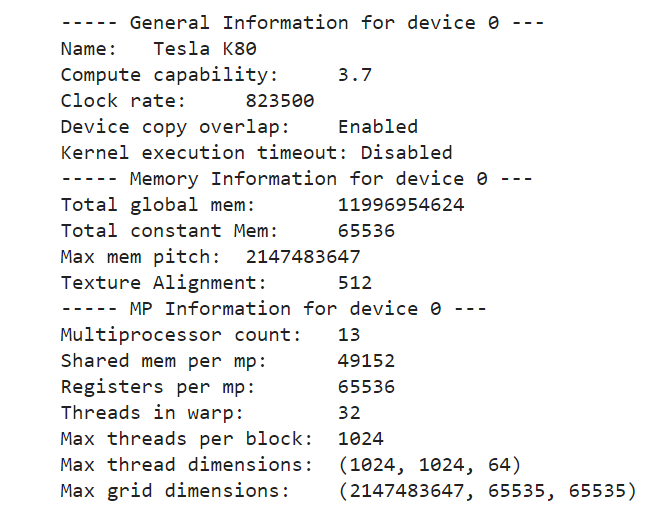

## Question 2. [+7]

**Simple CUDA code:** consider this loop for initializing an array **a**:

```c
const int n = 10000000 // 10 million
for (i = 0; i < n; i++)
    a[i] = (double)i / n;
```

Submit:

1.   The serial implementation running on the CPU.
2.   The CUDA implementation (1 thread per array element).  In your implementation, you will need to ensure:
    1. Memory on the card is correctly allocated (and the host as well)
    2. Data is properly divided up as well as defining the number of blocks in a grid and the number of threads per block
    3. Data is copied back from the card at the end of the kernel launch
    4. Data on the card is free'd when you are done. 

In both cases, add code to print the first and last 5 elements of the array to verify your code.  Add a text block commenting on the timing results.

*Note that you need to use the placeholder %.7f to print 7 digits after the decimal point.*

***Sample output:***

```c
a[0]: 0.0000000
a[1]: 0.0000001
a[2]: 0.0000002
a[3]: 0.0000003
a[4]: 0.0000004
...
a[9999995]: 0.9999995 
a[9999996]: 0.9999996 
a[9999997]: 0.9999997 
a[9999998]: 0.9999998 
a[9999999]: 0.9999999
```

***Note***:  You can find details on timing CUDA code at: https://developer.nvidia.com/blog/how-implement-performance-metrics-cuda-cc/ and https://programmerfish.com/profiling-cuda-kernels-and-wrapper-functions/.

***Marking Guide:***
+2 for the kernel function
+3 for launch configuration and properly calling the kernel
+2 for measuring the time of the parallel and serial code  

### CPU Implementation

Please code and run your CPU implementation in the code block below. When submitting your assignment, please copy the code block into a text/c file.

In [26]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

// CPU Implementation goes here!

#define N 10000000

void initializeVector(int* a, int n){
    for(int i=0;i<n;i++){
        a[i] = (double)i / n;
    }
}

int main() {
    int N = 10000000;
    int *a;

    a = malloc(N * sizeof(int));

    for(int i=0;i<N;i++){
        a[i]=i;
    }
    
    initializeVector(a, N);

    //print for testing:

    for(int i=0;i< 6;i++){
        printf("a[%d] : %0.7f ", i, a[i]); 
    }

    free(a);
    
}

/tmp/tmp7774n88v/c20af568-55ff-4eb7-a3c4-c2e77102f56f.cu(9): error: explicit type is missing ("int" assumed)

/tmp/tmp7774n88v/c20af568-55ff-4eb7-a3c4-c2e77102f56f.cu(13): warning: missing return statement at end of non-void function "initializeVector"

/tmp/tmp7774n88v/c20af568-55ff-4eb7-a3c4-c2e77102f56f.cu(16): error: expected an identifier

/tmp/tmp7774n88v/c20af568-55ff-4eb7-a3c4-c2e77102f56f.cu(19): error: a value of type "void *" cannot be assigned to an entity of type "int *"

3 errors detected in the compilation of "/tmp/tmp7774n88v/c20af568-55ff-4eb7-a3c4-c2e77102f56f.cu".



### CUDA Implementation

Please code and run your CUDA implementation in the code block below. When submitting your assignment, please copy the code block into a text/cu file.

In [23]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

// CUDA Implementation goes here!

#define N 10000000

__global__ void initializeVector(double *a, int n){
    int i= threadIdx.x;
    if(i<n)
        a[i] = ((double)i) / n;
    
}

int main() {
    
    int N = 10000000;
    double *a = new double[N];

    int *d_A;
    a = malloc(N * sizeof(int));

    cudaMalloc(&d_A, N * sizeof(int));

    cudaMemcpy(d_A, a, N * sizeof(int), cudeMemcpyHostToDevice);

    for(int i=0;i<N;i++){
        a[i]=i;
    }
    
    initializeVector<<<1,N>>>(d_A, N);

    cudaMemcpy(a, d_A, N * sizeof(int), cudaMemcpyDeviceToHost);

    //print for testing:

    for(int i=0;i< 6;i++){
        printf("a[%d] : %0.7f ", i, a[i]); 
    }
    for(int i=N - 5;i< 6;i++){
        printf("a[%d] : %0.7f ", i, a[i]); 
    }

    free(a);
    free(d_A);
    return 0;
}

/tmp/tmpr6bn4b4l/3832854e-b784-4ad3-81c5-c3d0dc6715aa.cu(18): error: expected an identifier

/tmp/tmpr6bn4b4l/3832854e-b784-4ad3-81c5-c3d0dc6715aa.cu(22): error: a value of type "void *" cannot be assigned to an entity of type "double *"

/tmp/tmpr6bn4b4l/3832854e-b784-4ad3-81c5-c3d0dc6715aa.cu(26): error: identifier "cudeMemcpyHostToDevice" is undefined

/tmp/tmpr6bn4b4l/3832854e-b784-4ad3-81c5-c3d0dc6715aa.cu(32): error: argument of type "int *" is incompatible with parameter of type "double *"

4 errors detected in the compilation of "/tmp/tmpr6bn4b4l/3832854e-b784-4ad3-81c5-c3d0dc6715aa.cu".



In [6]:
Comments on timing results:

SyntaxError: ignored

---

**Submission Instructions**

For this assignment, you need to do the following:

1. Save your A6.ipynb file from Colab to GitHub.    Make sure that this file is saved (you have a copy) and it is successfully commited to your repo.   Ensure that your code solutions are in your Notebook as they will be marked from there. 
2. Add the PNG file from Q1 and the source code file.

Note that you can resubmit an assignment, but the new submission overwrites the old submission and receives a new timestamp with GitHub.  Make sure to review the due date for this submission. 